# Salinity comparison

In [1]:
from __future__ import division, print_function
from salishsea_tools import (nc_tools,viz_tools,stormtools,tidetools)
from salishsea_tools.nowcast import figures
from datetime import datetime, timedelta
from pylab import *
from sklearn import linear_model
from glob import glob
from IPython.core.display import HTML
from salishsea_tools.nowcast import figures
import matplotlib.pyplot as plt
import scipy.io as sio
import netCDF4 as nc
import numpy as np
import math
#import glob
import os
import datetime
%matplotlib inline

In [2]:
title_font = {
    'fontname': 'Bitstream Vera Sans', 'size': '15', 'color': 'black',
    'weight': 'medium'
}
axis_font = {'fontname': 'Bitstream Vera Sans', 'size': '13'}

# For 1 day simulation with straight river channel function

In [3]:
def results_dataset(period, grid, results_dir):
    """Return the results dataset for period (e.g. 1h or 1d)
    and grid (e.g. grid_T, grid_U) from results_dir.
    """
    filename_pattern = 'SalishSea_{period}_*_{grid}.nc'
    filepaths = glob(os.path.join(results_dir, filename_pattern.format(period=period, grid=grid)))
    return  nc.Dataset(filepaths[0])

In [25]:
run_date = datetime.datetime(2015,6,15)
# Results dataset location
results_home = '/ocean/jieliu/research/meopar/river-treatment/24hrs_norles/'
results_dir = os.path.join(results_home, run_date.strftime('%d%b%y').lower())

In [26]:
def date(year, month, day_start, day_end, period, grid):
    
    day_range = np.arange(day_start, day_end+1)
    day_len = len(day_range)
    files_all = [None] * day_len
    inds = np.arange(day_len)
    
    for i, day in zip(inds, day_range):
        run_date = datetime.datetime(year,month, day)
        results_home = '/ocean/jieliu/research/meopar/river-treatment/24hrs_norles/'
        results_dir = os.path.join(results_home, run_date.strftime('%d%b%y').lower())
        filename = 'SalishSea_' + period + '_' + run_date.strftime('%Y%m%d').lower() + \
        '_' + run_date.strftime('%Y%m%d').lower() + '_' + grid + '.nc'
        file_single = os.path.join(results_dir, filename)
        files_all[i] = file_single

    return files_all

In [27]:
grid_T_hr = results_dataset('1h', 'grid_T', results_dir)
bathy = nc.Dataset('/ocean/jieliu/research/meopar/river-treatment/bathy_meter_SalishSea5.nc')
PNW_coastline = sio.loadmat('/ocean/rich/more/mmapbase/bcgeo/PNW.mat')
filepath_name = date(run_date.year,run_date.month,run_date.day,run_date.day,'1h','grid_T') 

In [28]:
latitude=grid_T_hr.variables['nav_lat'] 
longitude=grid_T_hr.variables['nav_lon']

In [29]:
sal_hr = grid_T_hr.variables['vosaline']
t, z = 3, 0
sal_hr = np.ma.masked_values(sal_hr[t, z], 0)

# Prepare salinity data

In [8]:
saline=sio.loadmat('/ocean/jieliu/research/meopar\
/autodataupdate/ferrydata/SBE1920150616.mat')

In [9]:
def find_dist (q, lon11, lat11, X, Y, bathy, longitude, latitude, saline_nemo_3rd, saline_nemo_4rd):
    k=0
    values =0
    valuess=0
    dist = np.zeros(9)
    weights = np.zeros(9)
    value_3rd=np.zeros(9)
    value_4rd=np.zeros(9)
    regr =linear_model.LinearRegression()
    regr.fit(lon11,lat11);
    regr.coef_

    [x1, j1] = tidetools.find_closest_model_point(lon11[q],regr.predict(lon11[q]),\
                                        X,Y,bathy,lon_tol=0.0052,lat_tol=0.00210,allow_land=False)
    for i in np.arange(x1-1,x1+2):
        for j in np.arange(j1-1,j1+2):
            dist[k]=tidetools.haversine(lon11[q],lat11[q],longitude[i,j],latitude[i,j])
            weights[k]=1.0/dist[k]
            value_3rd[k]=saline_nemo_3rd[i,j]*weights[k]
            value_4rd[k]=saline_nemo_4rd[i,j]*weights[k]
            values=values+value_3rd[k]
            valuess=valuess+value_4rd[k]
            k+=1
            
    return values, valuess, weights

In [10]:
def get_SS2_bathy_data():
    """Get the original Salish Sea 2 bathymetry and grid data
    e.g. bathy, X, Y = get_SS2_bathy_data()

    .. note::

        This function is deprecated due to hard-coding of
        :file:`/ocean/klesouef/` path.
        Use :py:func:`tidetools.get_bathy_data` instead.

    :returns: bathy, X, Y
    """
    grid = nc.Dataset(
        '/ocean/jieliu/research/meopar/nemo-forcing/grid/bathy_meter_SalishSea2.nc', 'r')
    bathy = grid.variables['Bathymetry'][:, :]
    X = grid.variables['nav_lon'][:, :]
    Y = grid.variables['nav_lat'][:, :]
    return bathy, X, Y

In [12]:
def get_SS3_bathy_data():
    """Get the Salish Sea 3 bathymetry and grid data
    e.g. bathy, X, Y = get_SS3_bathy_data()

    .. note::

        This function is deprecated due to hard-coding of
        :file:`/ocean/klesouef/` path.
        Use :py:func:`tidetools.get_bathy_data` instead.

    :returns: bathy, X, Y
    """
    grid = nc.Dataset(
        '/ocean/jieliu/research/meopar/river-treatment/bathy_meter_SalishSea3.nc', 'r')
    bathy = grid.variables['Bathymetry'][:, :]
    X = grid.variables['nav_lon'][:, :]
    Y = grid.variables['nav_lat'][:, :]
    return bathy, X, Y

In [11]:
def get_SS5_bathy_data():
    """Get the Salish Sea 5 bathymetry and grid data
    e.g. bathy, X, Y = get_SS5_bathy_data()

    .. note::

        This function is deprecated due to hard-coding of
        :file:`/ocean/klesouef/` path.
        Use :py:func:`tidetools.get_bathy_data` instead.

    :returns: bathy, X, Y
    """
    grid = nc.Dataset(
        '/ocean/jieliu/research/meopar/river-treatment/bathy_meter_SalishSea5.nc', 'r')
    bathy = grid.variables['Bathymetry'][:, :]
    X = grid.variables['nav_lon'][:, :]
    Y = grid.variables['nav_lat'][:, :]
    return bathy, X, Y

In [12]:
def salinity_fxn(saline):
    a=saline['ferryData']
    b=a['data']
    dataa = b[0,0]
    time=dataa['matlabtime'][0,0]
    lonn=dataa['Longitude'][0,0]
    latt=dataa['Latitude'][0,0]
    salinity=dataa['Practical_Salinity'][0,0]
    
    
    a=len(time)
    lon1=np.zeros([a,1])
    lat1=np.zeros([a,1])
    salinity1=np.zeros([a,1])
    for i in np.arange(0,a):
        matlab_datenum = np.float(time[i])
        python_datetime = datetime.datetime.fromordinal(int(matlab_datenum))\
        + timedelta(days=matlab_datenum%1) - timedelta(days = 366)
        
        if((python_datetime.year == run_date.year) & (python_datetime.month == run_date.month)\
           & (python_datetime.day == run_date.day)
           & (python_datetime.hour >= 3))&(python_datetime.hour < 5):
            lon1[i]=lonn[i]
            lat1[i]=latt[i]
            salinity1[i]=salinity[i]
            
    mask=lon1[:,0]!=0
    lon1_2_4=lon1[mask]
    lat1_2_4=lat1[mask]
    salinity1_2_4=salinity1[mask]
    lon11=lon1_2_4[0:-1:50]
    lat11=lat1_2_4[0:-1:50]
    salinity11=salinity1_2_4[0:-1:50]
    if results_home == '/ocean/jieliu/research/meopar/river-treatment/14days_norefraserxml/': 
        bathynew, X, Y = get_SS5_bathy_data()
    elif results_home == '/data/dlatorne/MEOPAR/SalishSea/nowcast/': 
        bathyold, X, Y = get_SS2_bathy_data()
    
    #bathy, X, Y = tidetools.get_SS2_bathy_data()
    
    #aa=date(run_date.year,run_date.month,run_date.day,run_date.day,'1h','grid_T') 
    #sim_date = datetime.datetime(2015,3,19)####need to change for \
    #different daily model results, construct a datetime object
    #run_date = datetime.datetime(2015,3,19)
    
    date_str = run_date.strftime('%d-%b-%Y') ##create a string based on this date
    tracers=nc.Dataset(filepath_name[0])
    #j=int(aa[0][65:67])
    #jj=int(aa[0][67:69])
    latitude=tracers.variables['nav_lat'][:] 
    longitude=tracers.variables['nav_lon'][:] 
    saline_nemo = tracers.variables['vosaline']
    saline_nemo_3rd = saline_nemo[3,0, 0:898, 0:398] 
    saline_nemo_4rd = saline_nemo[4,0, 0:898, 0:398]
    
    matrix=np.zeros([15,9])
    values=np.zeros([15,1])
    valuess=np.zeros([15,1])
    value_mean_3rd_hour=np.zeros([15,1])
    value_mean_4rd_hour=np.zeros([15,1]) 
    for q in np.arange(0,15):
        if results_home == '/ocean/jieliu/research/meopar/river-treatment/14days_norefraserxml/':
            values[q], valuess[q], matrix[q,:]=find_dist(q, lon11, lat11, X, Y,\
                                     bathynew, longitude, latitude, saline_nemo_3rd, saline_nemo_4rd)
            value_mean_3rd_hour[q]=values[q]/sum(matrix[q])
            value_mean_4rd_hour[q]=valuess[q]/sum(matrix[q])
        elif results_home == '/data/dlatorne/MEOPAR/SalishSea/nowcast/':
            values[q], valuess[q], matrix[q,:]=find_dist(q, lon11, lat11, X, Y,\
                                     bathyold, longitude, latitude, saline_nemo_3rd, saline_nemo_4rd)
            value_mean_3rd_hour[q]=values[q]/sum(matrix[q])
            value_mean_4rd_hour[q]=valuess[q]/sum(matrix[q])

    return lon11, lat11, value_mean_3rd_hour, value_mean_4rd_hour, salinity11, date_str

In [13]:
# Hides Deprecation warming - needs fixing
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [14]:
# Dictionary of ferry stations - new
ferry_stations = {'Tsawwassen': {'lat': 49.0084,'lon': -123.1281},
                  'Duke': {'lat': 49.1632,'lon': -123.8909},
                  'Vancouver': {'lat': 49.2827,'lon': -123.1207}}

In [15]:
def salinity_ferry_route(grid_T, grid_B, PNW_coastline,  sal_hr,ferry_sal):
    """ plot daily salinity comparisons between ferry observations 
    and model results as well as ferry route with model salinity 
    distribution.
    
    :arg grid_B: Bathymetry dataset for the Salish Sea NEMO model.
    :type grid_B: :class:`netCDF4.Dataset`
    
    :arg PNW_coastline: Coastline dataset.
    :type PNW_coastline: :class:`mat.Dataset`
    
    :arg ferry_sal: saline
    :type ferry_sal: numpy
    
    :returns: fig
    """

    fig, axs = plt.subplots(1, 2, figsize=(15, 8))

    figures.plot_map(axs[1], grid_B, PNW_coastline)
    axs[1].set_xlim(-124.5, -122.5)
    axs[1].set_ylim(48.2, 49.5)
    viz_tools.set_aspect(axs[1],coords='map',lats=latitude)
    cmap=plt.get_cmap('spectral')
    cmap.set_bad('burlywood')
    mesh=axs[1].pcolormesh(longitude[:],latitude[:],sal_hr[:],cmap=cmap)
    cbar=fig.colorbar(mesh)
    plt.setp(plt.getp(cbar.ax.axes, 'yticklabels'), color='w')
    cbar.set_label('Pratical Salinity', color='white')
    
    axs[1].set_title('Ferry Route: 3am[UTC] model result ', **title_font)
 
    bbox_args = dict(boxstyle='square', facecolor='white', alpha=0.7)
    stations=['Tsawwassen','Duke','Vancouver']
    for stn in stations:
        axs[1].plot(ferry_stations[stn]['lon'], ferry_stations[stn]['lat'], marker='D', \
                    color='white',\
                 markersize=10, markeredgewidth=2)
    axs[1].annotate ('Tsawwassen',(ferry_stations['Tsawwassen']['lon'] + 0.02,\
    ferry_stations['Tsawwassen']['lat'] + 0.12), fontsize=15, color='black', bbox=bbox_args )
    axs[1].annotate ('Duke',(ferry_stations['Duke']['lon'] - 0.35,\
    ferry_stations['Duke']['lat'] ),fontsize=15, color='black', bbox=bbox_args )
    axs[1].annotate ('Vancouver',(ferry_stations['Vancouver']['lon'] - 0.1,\
    ferry_stations['Vancouver']['lat']+ 0.09 ),fontsize=15, color='black', bbox=bbox_args )
    figures.axis_colors(axs[1], 'white')
    
    
    lon11, lat11, value_mean_3rd_hour, value_mean_4rd_hour, salinity11, date_str = salinity_fxn(saline)
    axs[1].plot(lon11,lat11,'black', linewidth = 4)
    model_salinity_3rd_hour=axs[0].plot(lon11,value_mean_3rd_hour,'DodgerBlue',\
                                    linewidth=2, label='3 am [UTC]')
    model_salinity_4rd_hour=axs[0].plot(lon11,value_mean_4rd_hour,'MediumBlue',\
                                        linewidth=2, label="4 am [UTC]" )
    observation_salinity=axs[0].plot(lon11,salinity11,'DarkGreen', linewidth=2, label="Observed")
    axs[0].text(0.25, -0.1,'Observations from Ocean Networks Canada', \
                transform=axs[0].transAxes, color='white')

    axs[0].set_xlim(-124, -123)
    axs[0].set_ylim(0, 30)
    axs[0].set_title('Surface Salinity: ' + date_str, **title_font)
    axs[0].set_xlabel('Longitude', **axis_font)
    axs[0].set_ylabel('Practical Salinity', **axis_font)
    axs[0].legend()
    axs[0].grid()
   

    fig.patch.set_facecolor('#2B3E50')
    figures.axis_colors(axs[0], 'gray')
    
    return fig

/home/jieliu/anaconda/lib/python2.7/site-packages/matplotlib/axes/_base.py:1057: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  if aspect == 'normal':
/home/jieliu/anaconda/lib/python2.7/site-packages/matplotlib/axes/_base.py:1062: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  elif aspect in ('equal', 'auto'):


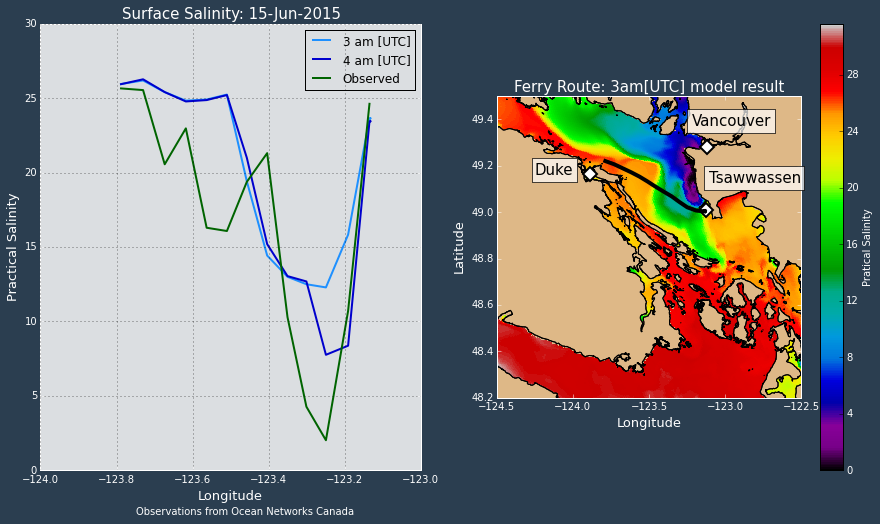

In [18]:
##complete result on orcinus
fig = salinity_ferry_route(grid_T_hr, bathy, PNW_coastline, sal_hr, saline)

1 Progress of the surface salinity around offshore area([-123.2, -123.0]) is nearly matching the obs.

2 Surface salinity around area (-123.4, -123.2) is still saltier. Firstly thought it might be caused by TS initial condition that I set S before New West as 4 psu which is relatively high salinity value in the river, but unsure about that as the north channel result show below. 

# For 1 day simulation with north not up to Howe river channel

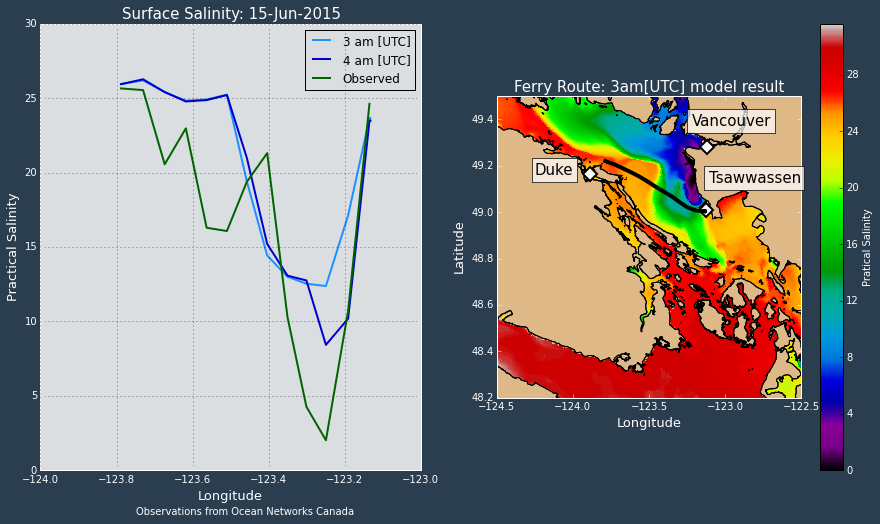

In [32]:
## north channel not up to Howe plot
fig = salinity_ferry_route(grid_T_hr, bathy, PNW_coastline, sal_hr, saline)

1 Not much difference compared with straight channel.

2 4am model result corresponds well with obs(nearly the same!!) in the area(-123.3, -123.0).

3 Same phenomenon of area(-123.4, -123.3) also exists

# For original result

In [22]:
def date(year, month, day_start, day_end, period, grid):
    
    day_range = np.arange(day_start, day_end+1)
    day_len = len(day_range)
    files_all = [None] * day_len
    inds = np.arange(day_len)
    
    for i, day in zip(inds, day_range):
        run_date = datetime.datetime(year,month, day)
        results_home = '/data/dlatorne/MEOPAR/SalishSea/nowcast/'
        results_dir = os.path.join(results_home, run_date.strftime('%d%b%y').lower())
        filename = 'SalishSea_' + period + '_' + run_date.strftime('%Y%m%d').lower() + \
        '_' + run_date.strftime('%Y%m%d').lower() + '_' + grid + '.nc'
        file_single = os.path.join(results_dir, filename)
        files_all[i] = file_single

    return files_all

In [20]:
run_date = datetime.datetime(2015,6,15)
# Results dataset location
results_home = '/data/dlatorne/MEOPAR/SalishSea/nowcast/'
results_dir = os.path.join(results_home, run_date.strftime('%d%b%y').lower())

In [21]:
grid_T_hr = results_dataset('1h', 'grid_T', results_dir)
bathy = nc.Dataset('/data/nsoontie/MEOPAR/NEMO-forcing/grid/bathy_meter_SalishSea2.nc')
PNW_coastline = sio.loadmat('/ocean/rich/more/mmapbase/bcgeo/PNW.mat')
filepath_name = date(run_date.year,run_date.month,run_date.day,run_date.day,'1h','grid_T') 
filepath_name

['/data/dlatorne/MEOPAR/SalishSea/nowcast/15jun15/SalishSea_1h_20150615_20150615_grid_T.nc']

In [22]:
latitude=grid_T_hr.variables['nav_lat'] 
longitude=grid_T_hr.variables['nav_lon']

In [23]:
sal_hr_ori = grid_T_hr.variables['vosaline']
t, z = 3, 0
sal_hr_ori = np.ma.masked_values(sal_hr_ori[t, z], 0)

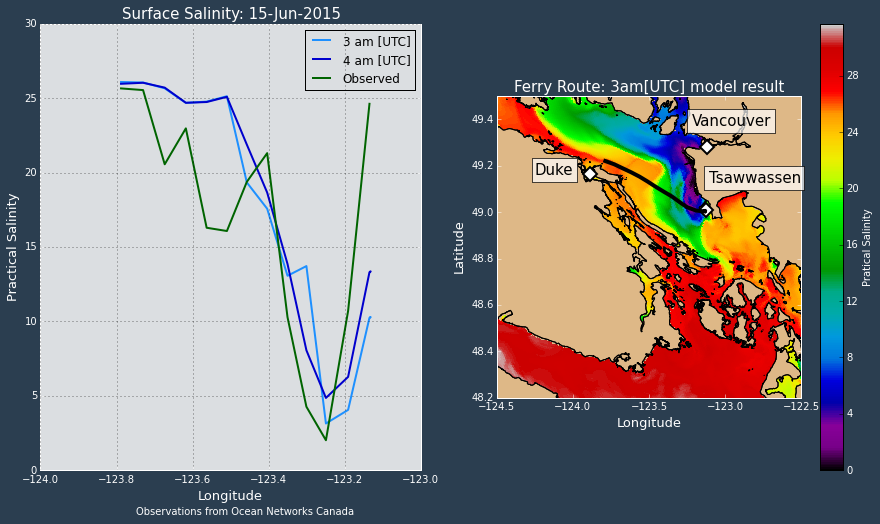

In [24]:
## original plot
fig = salinity_ferry_route(grid_T_hr, bathy, PNW_coastline,sal_hr_ori, saline)

# For 14 days simulation with north not up to Howe river channel

June 16

In [30]:
run_date = datetime.datetime(2015,6,16)
# Results dataset location
results_home = '/ocean/jieliu/research/meopar/river-treatment/14days_norefraserxml/'
results_dir = os.path.join(results_home, run_date.strftime('%d%b%y').lower())

In [4]:
def date_more(year, month, day_start, day_end, period, grid):
    
    day_range = np.arange(day_start, day_end+1)
    day_len = len(day_range)
    files_all = [None] * day_len
    inds = np.arange(day_len)
    
    for i, day in zip(inds, day_range):
        run_date = datetime.datetime(year,month, day)
        if results_home == '/ocean/jieliu/research/meopar/river-treatment/14days_norefraserxml/':           
            results_dir = os.path.join(results_home, run_date.strftime('%d%b%y').lower())
            filename = 'SalishSea_' + period + '_' + run_date.strftime('%Y%m%d').lower() + \
            '_' + run_date.strftime('%Y%m%d').lower() + '_' + grid + '.nc'
            file_single = os.path.join(results_dir, filename)
            files_all[i] = file_single
        elif results_home == '/data/dlatorne/MEOPAR/SalishSea/nowcast/':
            results_dir = os.path.join(results_home, run_date.strftime('%d%b%y').lower())
            filename = 'SalishSea_' + period + '_' + run_date.strftime('%Y%m%d').lower() + \
            '_' + run_date.strftime('%Y%m%d').lower() + '_' + grid + '.nc'
            file_single = os.path.join(results_dir, filename)
            files_all[i] = file_single

    return files_all

In [32]:
grid_T_hr = results_dataset('1h', 'grid_T', results_dir)
bathy = nc.Dataset('/ocean/jieliu/research/meopar/river-treatment/bathy_meter_SalishSea5.nc')
PNW_coastline = sio.loadmat('/ocean/rich/more/mmapbase/bcgeo/PNW.mat')
filepath_name = date_more(run_date.year,run_date.month,run_date.day,run_date.day,'1h','grid_T') 

['/ocean/jieliu/research/meopar/river-treatment/14days_norefraserxml/16jun15/SalishSea_1h_20150616_20150616_grid_T.nc']

In [8]:
latitude=grid_T_hr.variables['nav_lat'] 
longitude=grid_T_hr.variables['nav_lon']

In [9]:
sal_hr = grid_T_hr.variables['vosaline']
t, z = 3, 0
sal_hr = np.ma.masked_values(sal_hr[t, z], 0)

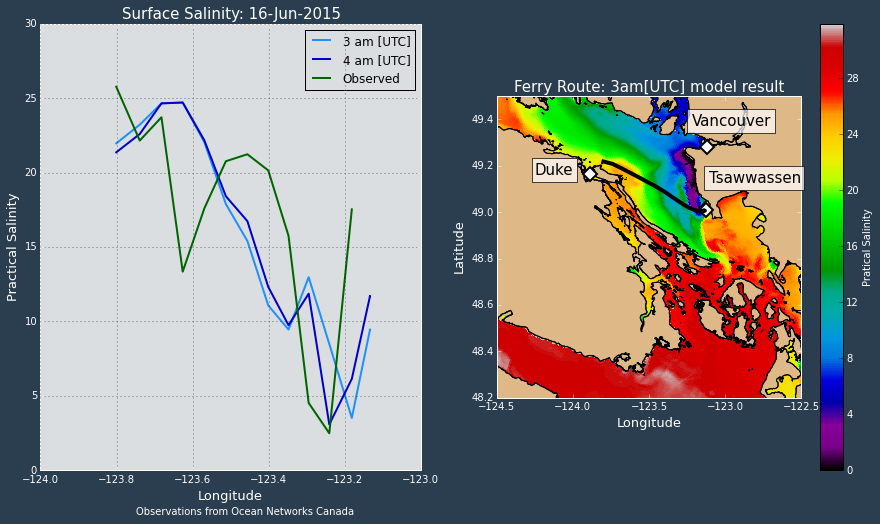

In [21]:
##new result June 16 
fig = salinity_ferry_route(grid_T_hr, bathy, PNW_coastline, sal_hr, saline)

original result


In [23]:
run_date = datetime.datetime(2015,6,16)
# Results dataset location
results_home = '/data/dlatorne/MEOPAR/SalishSea/nowcast/'
results_dir = os.path.join(results_home, run_date.strftime('%d%b%y').lower())

In [24]:
grid_T_hr = results_dataset('1h', 'grid_T', results_dir)
bathy = nc.Dataset('/data/nsoontie/MEOPAR/NEMO-forcing/grid/bathy_meter_SalishSea2.nc')
PNW_coastline = sio.loadmat('/ocean/rich/more/mmapbase/bcgeo/PNW.mat')
filepath_name = date_more(run_date.year,run_date.month,run_date.day,run_date.day,'1h','grid_T')

In [25]:
latitude=grid_T_hr.variables['nav_lat'] 
longitude=grid_T_hr.variables['nav_lon']
sal_hr_ori = grid_T_hr.variables['vosaline']
t, z = 3, 0
sal_hr_ori = np.ma.masked_values(sal_hr_ori[t, z], 0)

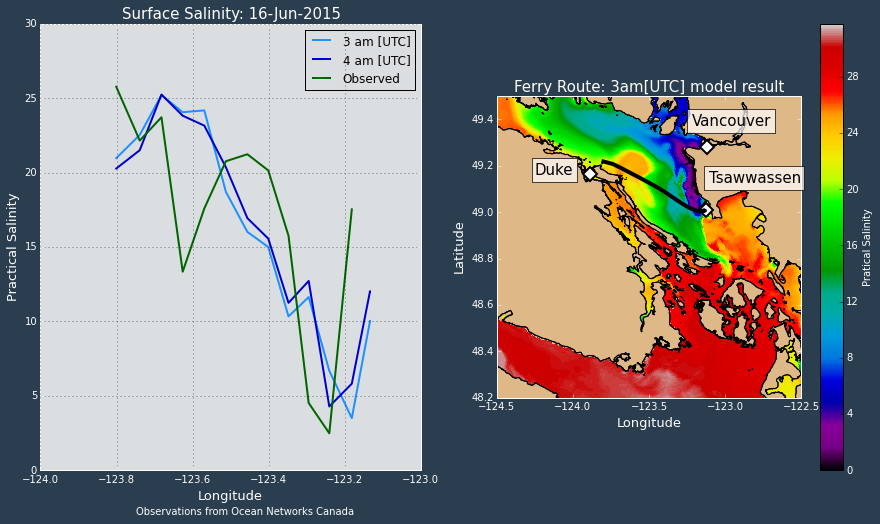

In [26]:
## original plot
fig = salinity_ferry_route(grid_T_hr, bathy, PNW_coastline,sal_hr_ori, saline)

New June 17

In [5]:
run_date = datetime.datetime(2015,6,17)
# Results dataset location
results_home = '/ocean/jieliu/research/meopar/river-treatment/14days_norefraserxml/'
results_dir = os.path.join(results_home, run_date.strftime('%d%b%y').lower())

In [6]:
grid_T_hr = results_dataset('1h', 'grid_T', results_dir)
bathy = nc.Dataset('/ocean/jieliu/research/meopar/river-treatment/bathy_meter_SalishSea5.nc')
PNW_coastline = sio.loadmat('/ocean/rich/more/mmapbase/bcgeo/PNW.mat')
filepath_name = date_more(run_date.year,run_date.month,run_date.day,run_date.day,'1h','grid_T') 

In [7]:
latitude=grid_T_hr.variables['nav_lat'] 
longitude=grid_T_hr.variables['nav_lon']
sal_hr = grid_T_hr.variables['vosaline']
t, z = 3, 0
sal_hr = np.ma.masked_values(sal_hr[t, z], 0)

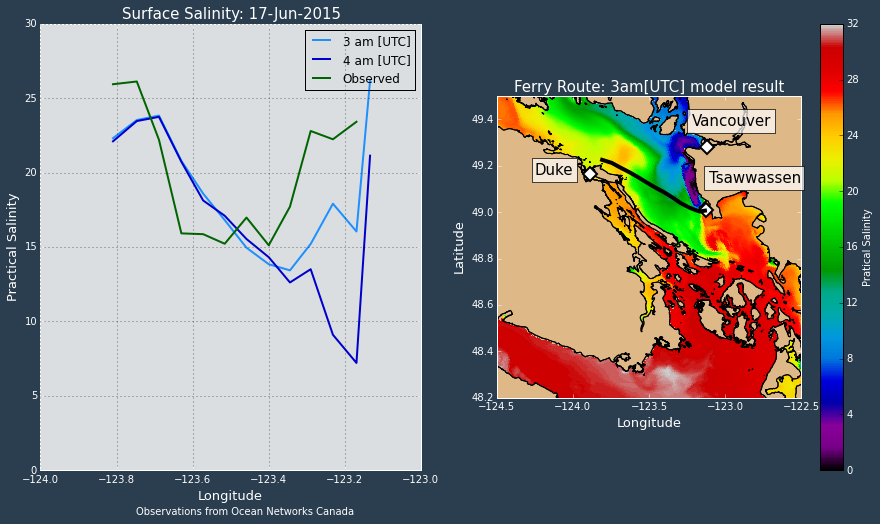

In [17]:
##new result June 17 
fig = salinity_ferry_route(grid_T_hr, bathy, PNW_coastline, sal_hr, saline)

* Not much variation compared with original except for the offshore saltier which is slightly match with the obs salinity values.

original June 17

In [18]:
run_date = datetime.datetime(2015,6,17)
# Results dataset location
results_home = '/data/dlatorne/MEOPAR/SalishSea/nowcast/'
results_dir = os.path.join(results_home, run_date.strftime('%d%b%y').lower())

In [19]:
grid_T_hr = results_dataset('1h', 'grid_T', results_dir)
bathy = nc.Dataset('/data/nsoontie/MEOPAR/NEMO-forcing/grid/bathy_meter_SalishSea2.nc')
PNW_coastline = sio.loadmat('/ocean/rich/more/mmapbase/bcgeo/PNW.mat')
filepath_name = date_more(run_date.year,run_date.month,run_date.day,run_date.day,'1h','grid_T')

In [20]:
latitude=grid_T_hr.variables['nav_lat'] 
longitude=grid_T_hr.variables['nav_lon']
sal_hr_ori = grid_T_hr.variables['vosaline']
t, z = 3, 0
sal_hr_ori = np.ma.masked_values(sal_hr_ori[t, z], 0)

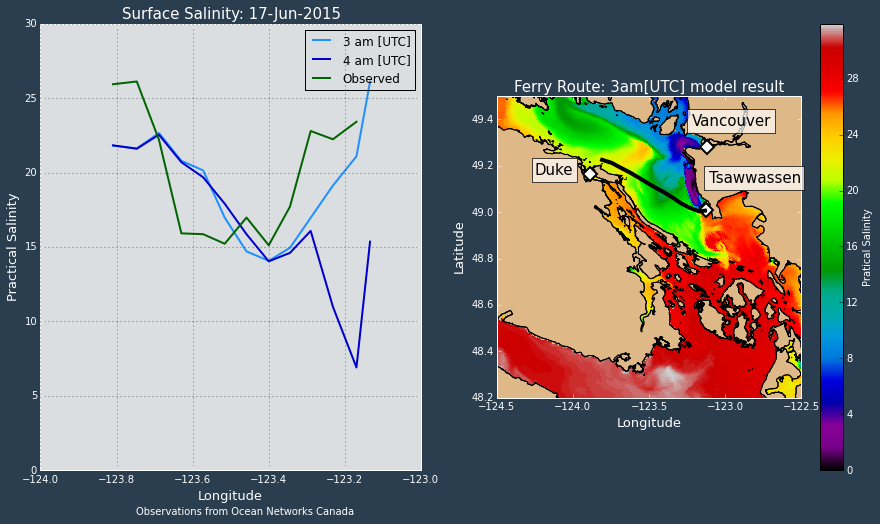

In [21]:
## original plot
fig = salinity_ferry_route(grid_T_hr, bathy, PNW_coastline,sal_hr_ori, saline)

New June 18

In [22]:
saline=sio.loadmat('/ocean/jieliu/research/meopar\
/autodataupdate/ferrydata/SBE1920150617.mat')

In [23]:
run_date = datetime.datetime(2015,6,18)
# Results dataset location
results_home = '/ocean/jieliu/research/meopar/river-treatment/14days_norefraserxml/'
results_dir = os.path.join(results_home, run_date.strftime('%d%b%y').lower())

In [24]:
grid_T_hr = results_dataset('1h', 'grid_T', results_dir)
bathy = nc.Dataset('/ocean/jieliu/research/meopar/river-treatment/bathy_meter_SalishSea5.nc')
PNW_coastline = sio.loadmat('/ocean/rich/more/mmapbase/bcgeo/PNW.mat')
filepath_name = date_more(run_date.year,run_date.month,run_date.day,run_date.day,'1h','grid_T') 

In [25]:
latitude=grid_T_hr.variables['nav_lat'] 
longitude=grid_T_hr.variables['nav_lon']
sal_hr = grid_T_hr.variables['vosaline']
t, z = 3, 0
sal_hr = np.ma.masked_values(sal_hr[t, z], 0)

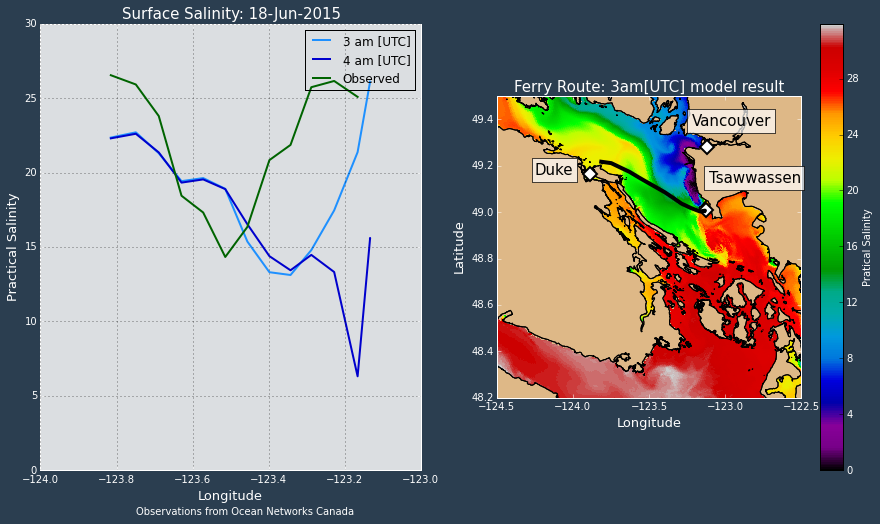

In [26]:
##new result June 18 
fig = salinity_ferry_route(grid_T_hr, bathy, PNW_coastline, sal_hr, saline)

* Worse than original as the postion of plume not correct, overdo???

orginal June 18

In [27]:
run_date = datetime.datetime(2015,6,18)
# Results dataset location
results_home = '/data/dlatorne/MEOPAR/SalishSea/nowcast/'
results_dir = os.path.join(results_home, run_date.strftime('%d%b%y').lower())

In [28]:
grid_T_hr = results_dataset('1h', 'grid_T', results_dir)
bathy = nc.Dataset('/data/nsoontie/MEOPAR/NEMO-forcing/grid/bathy_meter_SalishSea2.nc')
PNW_coastline = sio.loadmat('/ocean/rich/more/mmapbase/bcgeo/PNW.mat')
filepath_name = date_more(run_date.year,run_date.month,run_date.day,run_date.day,'1h','grid_T')

In [29]:
latitude=grid_T_hr.variables['nav_lat'] 
longitude=grid_T_hr.variables['nav_lon']
sal_hr_ori = grid_T_hr.variables['vosaline']
t, z = 3, 0
sal_hr_ori = np.ma.masked_values(sal_hr_ori[t, z], 0)

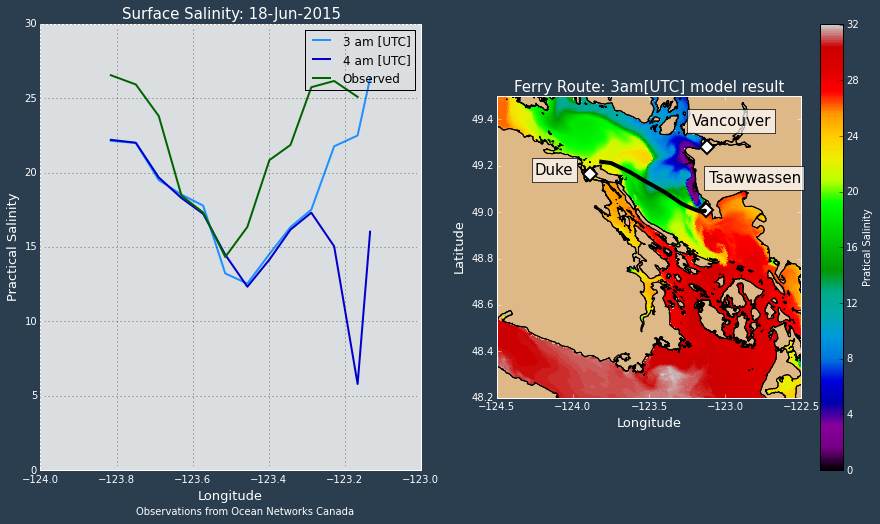

In [30]:
## original plot
fig = salinity_ferry_route(grid_T_hr, bathy, PNW_coastline,sal_hr_ori, saline)

New June 22

In [31]:
saline=sio.loadmat('/ocean/jieliu/research/meopar\
/autodataupdate/ferrydata/SBE1920150621.mat')

In [32]:
run_date = datetime.datetime(2015,6,22)
# Results dataset location
results_home = '/ocean/jieliu/research/meopar/river-treatment/14days_norefraserxml/'
results_dir = os.path.join(results_home, run_date.strftime('%d%b%y').lower())

In [33]:
grid_T_hr = results_dataset('1h', 'grid_T', results_dir)
bathy = nc.Dataset('/ocean/jieliu/research/meopar/river-treatment/bathy_meter_SalishSea5.nc')
PNW_coastline = sio.loadmat('/ocean/rich/more/mmapbase/bcgeo/PNW.mat')
filepath_name = date_more(run_date.year,run_date.month,run_date.day,run_date.day,'1h','grid_T') 

In [34]:
latitude=grid_T_hr.variables['nav_lat'] 
longitude=grid_T_hr.variables['nav_lon']
sal_hr = grid_T_hr.variables['vosaline']
t, z = 3, 0
sal_hr = np.ma.masked_values(sal_hr[t, z], 0)

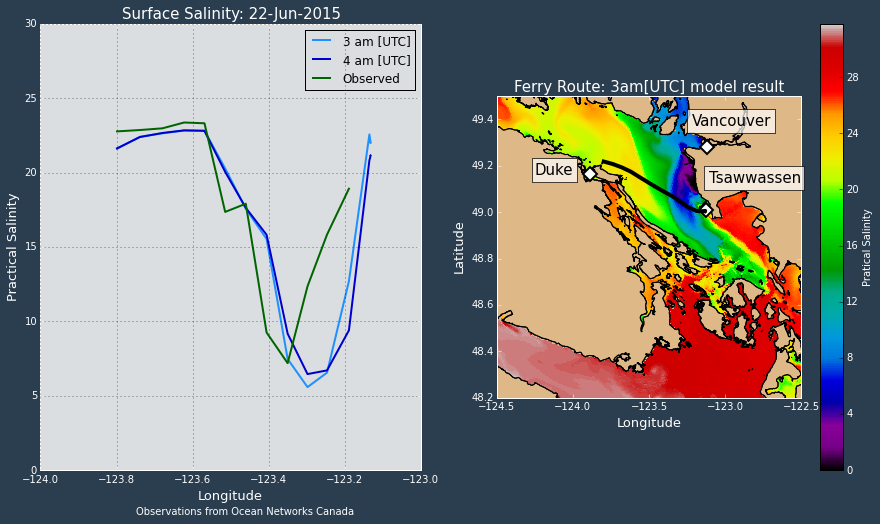

In [35]:
##new result June 22 
fig = salinity_ferry_route(grid_T_hr, bathy, PNW_coastline, sal_hr, saline)

* Slightly better than original June 22 model result in the longitude range between -123.8 and -123.4, position of minimun salinity value moves westward a little bit which seems to match the obs more.

original June 22

In [36]:
run_date = datetime.datetime(2015,6,22)
# Results dataset location
results_home = '/data/dlatorne/MEOPAR/SalishSea/nowcast/'
results_dir = os.path.join(results_home, run_date.strftime('%d%b%y').lower())

In [37]:
grid_T_hr = results_dataset('1h', 'grid_T', results_dir)
bathy = nc.Dataset('/data/nsoontie/MEOPAR/NEMO-forcing/grid/bathy_meter_SalishSea2.nc')
PNW_coastline = sio.loadmat('/ocean/rich/more/mmapbase/bcgeo/PNW.mat')
filepath_name = date_more(run_date.year,run_date.month,run_date.day,run_date.day,'1h','grid_T')
latitude=grid_T_hr.variables['nav_lat'] 
longitude=grid_T_hr.variables['nav_lon']
sal_hr_ori = grid_T_hr.variables['vosaline']
t, z = 3, 0
sal_hr_ori = np.ma.masked_values(sal_hr_ori[t, z], 0)

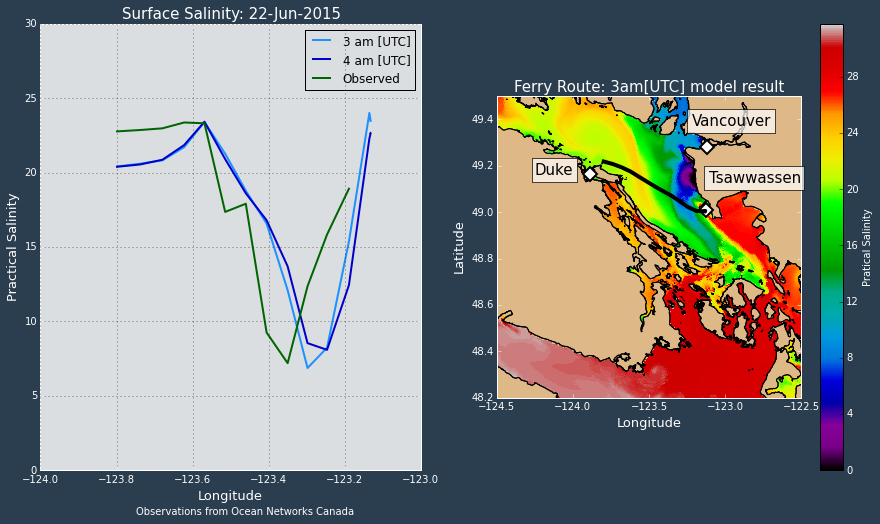

In [38]:
## original plot
fig = salinity_ferry_route(grid_T_hr, bathy, PNW_coastline,sal_hr_ori, saline)

New June 23

In [40]:
saline=sio.loadmat('/ocean/jieliu/research/meopar\
/autodataupdate/ferrydata/SBE1920150622.mat')

In [39]:
run_date = datetime.datetime(2015,6,23)
# Results dataset location
results_home = '/ocean/jieliu/research/meopar/river-treatment/14days_norefraserxml/'
results_dir = os.path.join(results_home, run_date.strftime('%d%b%y').lower())

In [41]:
grid_T_hr = results_dataset('1h', 'grid_T', results_dir)
bathy = nc.Dataset('/ocean/jieliu/research/meopar/river-treatment/bathy_meter_SalishSea5.nc')
PNW_coastline = sio.loadmat('/ocean/rich/more/mmapbase/bcgeo/PNW.mat')
filepath_name = date_more(run_date.year,run_date.month,run_date.day,run_date.day,'1h','grid_T')
latitude=grid_T_hr.variables['nav_lat'] 
longitude=grid_T_hr.variables['nav_lon']
sal_hr = grid_T_hr.variables['vosaline']
t, z = 3, 0
sal_hr = np.ma.masked_values(sal_hr[t, z], 0)

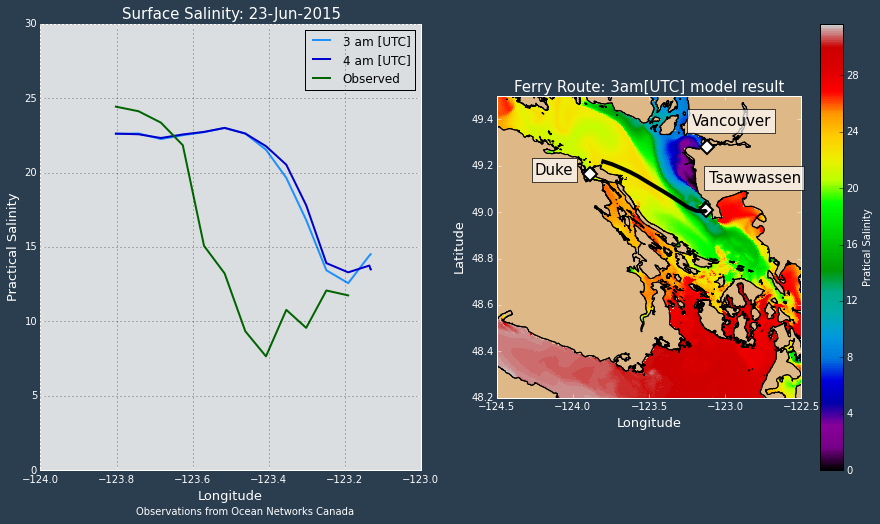

In [42]:
##new result June 23 
fig = salinity_ferry_route(grid_T_hr, bathy, PNW_coastline, sal_hr, saline)

*  Better interpretion of offshore salinity values than original, other parts do not vary much.

Original June 23

In [43]:
run_date = datetime.datetime(2015,6,23)
# Results dataset location
results_home = '/data/dlatorne/MEOPAR/SalishSea/nowcast/'
results_dir = os.path.join(results_home, run_date.strftime('%d%b%y').lower())

In [44]:
grid_T_hr = results_dataset('1h', 'grid_T', results_dir)
bathy = nc.Dataset('/data/nsoontie/MEOPAR/NEMO-forcing/grid/bathy_meter_SalishSea2.nc')
PNW_coastline = sio.loadmat('/ocean/rich/more/mmapbase/bcgeo/PNW.mat')
filepath_name = date_more(run_date.year,run_date.month,run_date.day,run_date.day,'1h','grid_T')
latitude=grid_T_hr.variables['nav_lat'] 
longitude=grid_T_hr.variables['nav_lon']
sal_hr_ori = grid_T_hr.variables['vosaline']
t, z = 3, 0
sal_hr_ori = np.ma.masked_values(sal_hr_ori[t, z], 0)

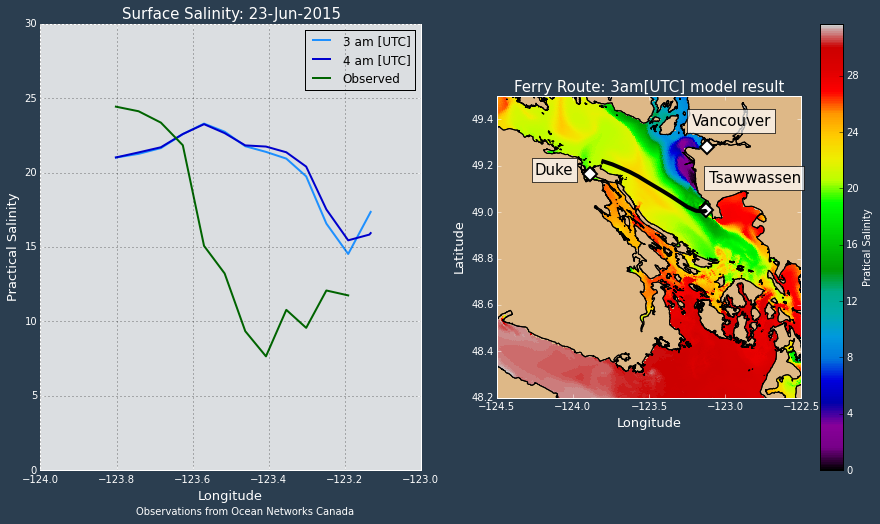

In [45]:
## original plot
fig = salinity_ferry_route(grid_T_hr, bathy, PNW_coastline,sal_hr_ori, saline)

New June 24

In [46]:
saline=sio.loadmat('/ocean/jieliu/research/meopar\
/autodataupdate/ferrydata/SBE1920150623.mat')

In [47]:
run_date = datetime.datetime(2015,6,24)
# Results dataset location
results_home = '/ocean/jieliu/research/meopar/river-treatment/14days_norefraserxml/'
results_dir = os.path.join(results_home, run_date.strftime('%d%b%y').lower())

In [48]:
grid_T_hr = results_dataset('1h', 'grid_T', results_dir)
bathy = nc.Dataset('/ocean/jieliu/research/meopar/river-treatment/bathy_meter_SalishSea5.nc')
PNW_coastline = sio.loadmat('/ocean/rich/more/mmapbase/bcgeo/PNW.mat')
filepath_name = date_more(run_date.year,run_date.month,run_date.day,run_date.day,'1h','grid_T')
latitude=grid_T_hr.variables['nav_lat'] 
longitude=grid_T_hr.variables['nav_lon']
sal_hr = grid_T_hr.variables['vosaline']
t, z = 3, 0
sal_hr = np.ma.masked_values(sal_hr[t, z], 0)

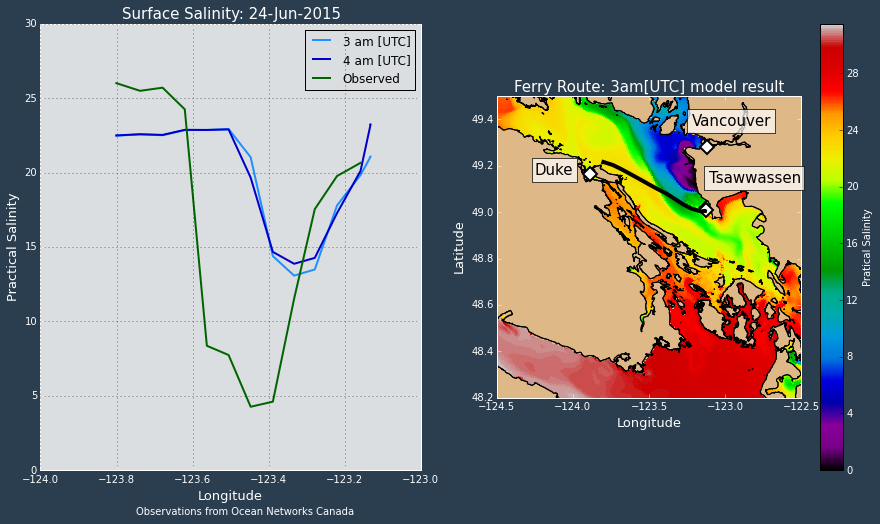

In [49]:
##new result June 24 
fig = salinity_ferry_route(grid_T_hr, bathy, PNW_coastline, sal_hr, saline)

* Decrease the discrepency between minimum salinity values of obs and mods, but still salty offshore.

orginal June 24

In [53]:
run_date = datetime.datetime(2015,6,24)
# Results dataset location
results_home = '/data/dlatorne/MEOPAR/SalishSea/nowcast/'
results_dir = os.path.join(results_home, run_date.strftime('%d%b%y').lower())

In [54]:
grid_T_hr = results_dataset('1h', 'grid_T', results_dir)
bathy = nc.Dataset('/data/nsoontie/MEOPAR/NEMO-forcing/grid/bathy_meter_SalishSea2.nc')
PNW_coastline = sio.loadmat('/ocean/rich/more/mmapbase/bcgeo/PNW.mat')
filepath_name = date_more(run_date.year,run_date.month,run_date.day,run_date.day,'1h','grid_T')
latitude=grid_T_hr.variables['nav_lat'] 
longitude=grid_T_hr.variables['nav_lon']
sal_hr_ori = grid_T_hr.variables['vosaline']
t, z = 3, 0
sal_hr_ori = np.ma.masked_values(sal_hr_ori[t, z], 0)

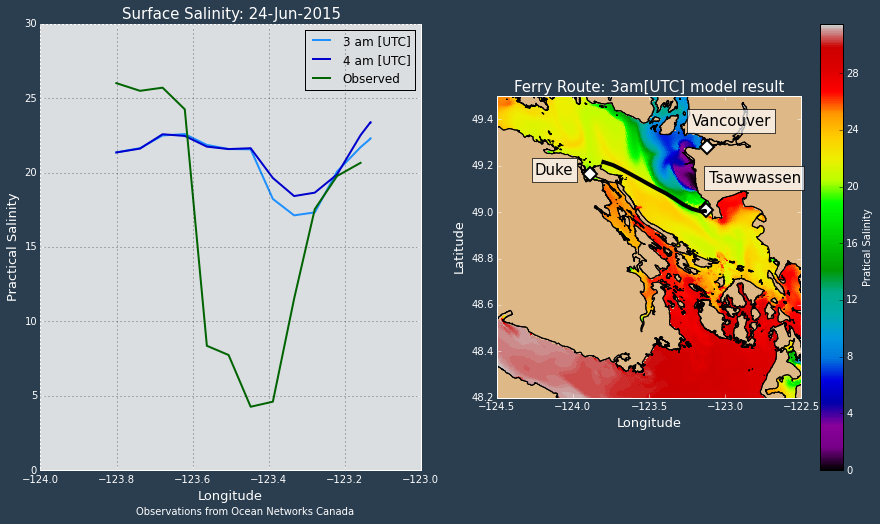

In [55]:
## original plot
fig = salinity_ferry_route(grid_T_hr, bathy, PNW_coastline,sal_hr_ori, saline)

New June 25

In [56]:
saline=sio.loadmat('/ocean/jieliu/research/meopar\
/autodataupdate/ferrydata/SBE1920150624.mat')

In [57]:
run_date = datetime.datetime(2015,6,25)
# Results dataset location
results_home = '/ocean/jieliu/research/meopar/river-treatment/14days_norefraserxml/'
results_dir = os.path.join(results_home, run_date.strftime('%d%b%y').lower())

In [58]:
grid_T_hr = results_dataset('1h', 'grid_T', results_dir)
bathy = nc.Dataset('/ocean/jieliu/research/meopar/river-treatment/bathy_meter_SalishSea5.nc')
PNW_coastline = sio.loadmat('/ocean/rich/more/mmapbase/bcgeo/PNW.mat')
filepath_name = date_more(run_date.year,run_date.month,run_date.day,run_date.day,'1h','grid_T')
latitude=grid_T_hr.variables['nav_lat'] 
longitude=grid_T_hr.variables['nav_lon']
sal_hr = grid_T_hr.variables['vosaline']
t, z = 3, 0
sal_hr = np.ma.masked_values(sal_hr[t, z], 0)

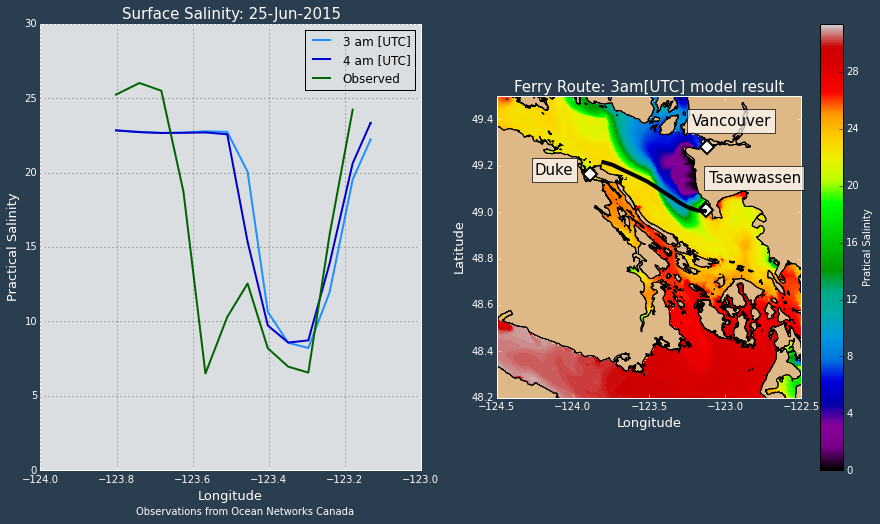

In [59]:
##new result June 25 
fig = salinity_ferry_route(grid_T_hr, bathy, PNW_coastline, sal_hr, saline)

* Better than original result.

original June 25

In [60]:
run_date = datetime.datetime(2015,6,25)
# Results dataset location
results_home = '/data/dlatorne/MEOPAR/SalishSea/nowcast/'
results_dir = os.path.join(results_home, run_date.strftime('%d%b%y').lower())

In [61]:
grid_T_hr = results_dataset('1h', 'grid_T', results_dir)
bathy = nc.Dataset('/data/nsoontie/MEOPAR/NEMO-forcing/grid/bathy_meter_SalishSea2.nc')
PNW_coastline = sio.loadmat('/ocean/rich/more/mmapbase/bcgeo/PNW.mat')
filepath_name = date_more(run_date.year,run_date.month,run_date.day,run_date.day,'1h','grid_T')
latitude=grid_T_hr.variables['nav_lat'] 
longitude=grid_T_hr.variables['nav_lon']
sal_hr_ori = grid_T_hr.variables['vosaline']
t, z = 3, 0
sal_hr_ori = np.ma.masked_values(sal_hr_ori[t, z], 0)

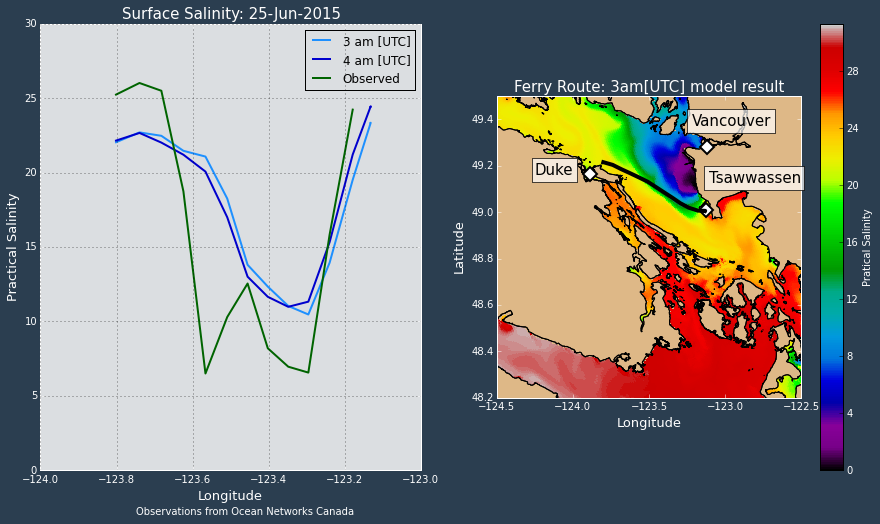

In [62]:
## original plot
fig = salinity_ferry_route(grid_T_hr, bathy, PNW_coastline,sal_hr_ori, saline)

New June 26

In [63]:
saline=sio.loadmat('/ocean/jieliu/research/meopar\
/autodataupdate/ferrydata/SBE1920150625.mat')

In [64]:
run_date = datetime.datetime(2015,6,26)
# Results dataset location
results_home = '/ocean/jieliu/research/meopar/river-treatment/14days_norefraserxml/'
results_dir = os.path.join(results_home, run_date.strftime('%d%b%y').lower())

In [65]:
grid_T_hr = results_dataset('1h', 'grid_T', results_dir)
bathy = nc.Dataset('/ocean/jieliu/research/meopar/river-treatment/bathy_meter_SalishSea5.nc')
PNW_coastline = sio.loadmat('/ocean/rich/more/mmapbase/bcgeo/PNW.mat')
filepath_name = date_more(run_date.year,run_date.month,run_date.day,run_date.day,'1h','grid_T')
latitude=grid_T_hr.variables['nav_lat'] 
longitude=grid_T_hr.variables['nav_lon']
sal_hr = grid_T_hr.variables['vosaline']
t, z = 3, 0
sal_hr = np.ma.masked_values(sal_hr[t, z], 0)

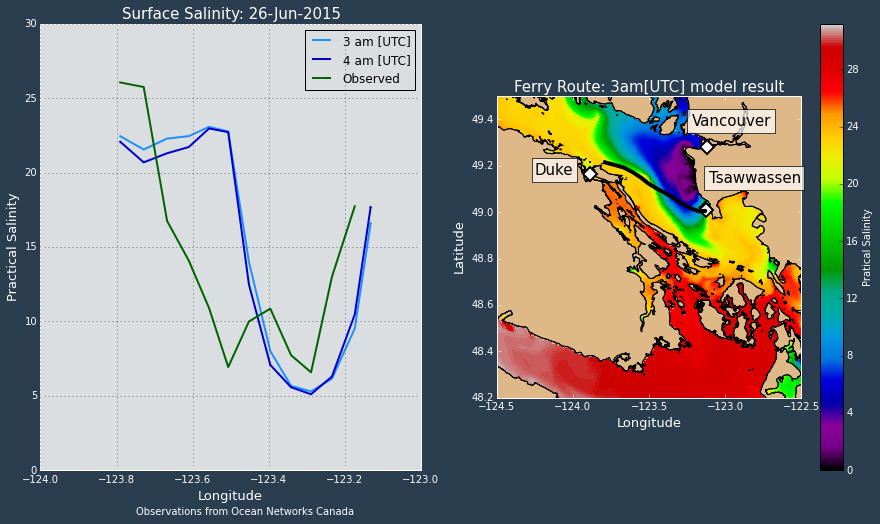

In [66]:
##new result June 26 
fig = salinity_ferry_route(grid_T_hr, bathy, PNW_coastline, sal_hr, saline)

* Worse than original result, I think. Position of plume not correct, seems to exist a lag.

original June 26

In [67]:
run_date = datetime.datetime(2015,6,26)
# Results dataset location
results_home = '/data/dlatorne/MEOPAR/SalishSea/nowcast/'
results_dir = os.path.join(results_home, run_date.strftime('%d%b%y').lower())

In [68]:
grid_T_hr = results_dataset('1h', 'grid_T', results_dir)
bathy = nc.Dataset('/data/nsoontie/MEOPAR/NEMO-forcing/grid/bathy_meter_SalishSea2.nc')
PNW_coastline = sio.loadmat('/ocean/rich/more/mmapbase/bcgeo/PNW.mat')
filepath_name = date_more(run_date.year,run_date.month,run_date.day,run_date.day,'1h','grid_T')
latitude=grid_T_hr.variables['nav_lat'] 
longitude=grid_T_hr.variables['nav_lon']
sal_hr_ori = grid_T_hr.variables['vosaline']
t, z = 3, 0
sal_hr_ori = np.ma.masked_values(sal_hr_ori[t, z], 0)

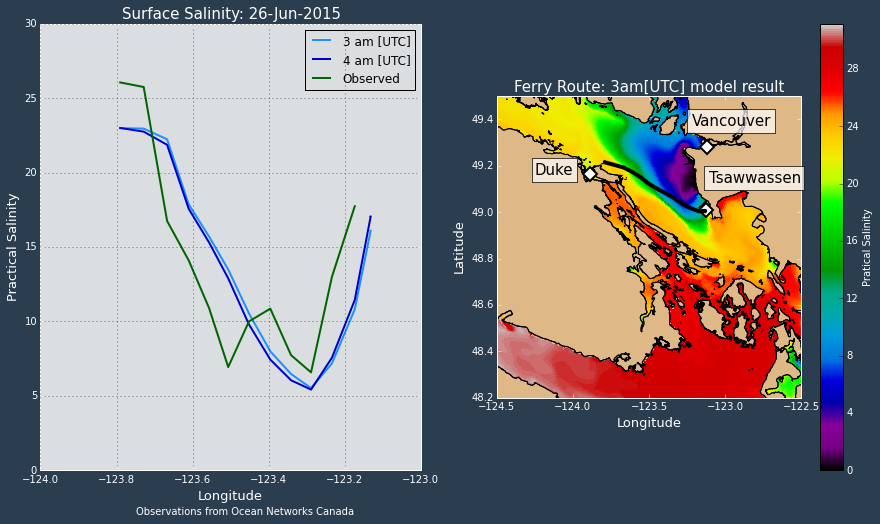

In [69]:
## original plot
fig = salinity_ferry_route(grid_T_hr, bathy, PNW_coastline,sal_hr_ori, saline)

New June 27

In [70]:
saline=sio.loadmat('/ocean/jieliu/research/meopar\
/autodataupdate/ferrydata/SBE1920150626.mat')

In [71]:
run_date = datetime.datetime(2015,6,27)
# Results dataset location
results_home = '/ocean/jieliu/research/meopar/river-treatment/14days_norefraserxml/'
results_dir = os.path.join(results_home, run_date.strftime('%d%b%y').lower())

In [72]:
grid_T_hr = results_dataset('1h', 'grid_T', results_dir)
bathy = nc.Dataset('/ocean/jieliu/research/meopar/river-treatment/bathy_meter_SalishSea5.nc')
PNW_coastline = sio.loadmat('/ocean/rich/more/mmapbase/bcgeo/PNW.mat')
filepath_name = date_more(run_date.year,run_date.month,run_date.day,run_date.day,'1h','grid_T')
latitude=grid_T_hr.variables['nav_lat'] 
longitude=grid_T_hr.variables['nav_lon']
sal_hr = grid_T_hr.variables['vosaline']
t, z = 3, 0
sal_hr = np.ma.masked_values(sal_hr[t, z], 0)

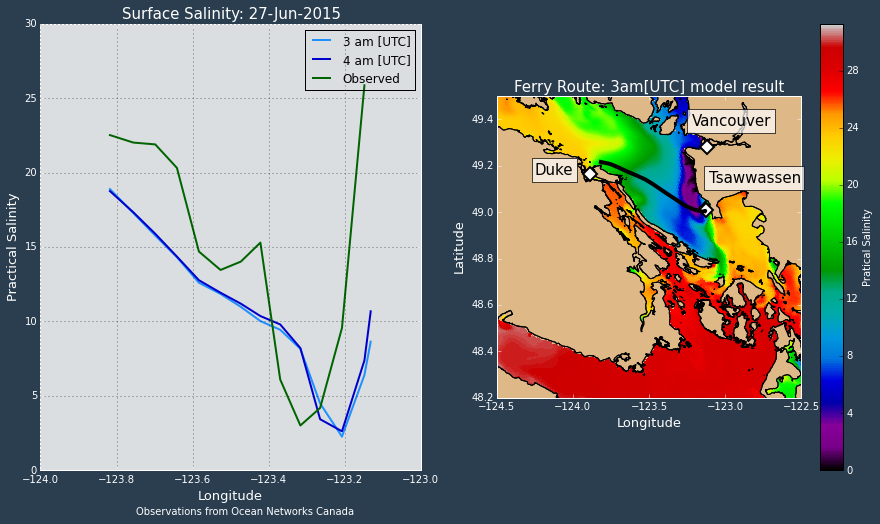

In [73]:
##new result June 27 
fig = salinity_ferry_route(grid_T_hr, bathy, PNW_coastline, sal_hr, saline)

* Slightly better than original with nearly the same minimum salinity, but the position of plume is still not right. 

original June 27

In [74]:
run_date = datetime.datetime(2015,6,27)
# Results dataset location
results_home = '/data/dlatorne/MEOPAR/SalishSea/nowcast/'
results_dir = os.path.join(results_home, run_date.strftime('%d%b%y').lower())

In [75]:
grid_T_hr = results_dataset('1h', 'grid_T', results_dir)
bathy = nc.Dataset('/data/nsoontie/MEOPAR/NEMO-forcing/grid/bathy_meter_SalishSea2.nc')
PNW_coastline = sio.loadmat('/ocean/rich/more/mmapbase/bcgeo/PNW.mat')
filepath_name = date_more(run_date.year,run_date.month,run_date.day,run_date.day,'1h','grid_T')
latitude=grid_T_hr.variables['nav_lat'] 
longitude=grid_T_hr.variables['nav_lon']
sal_hr_ori = grid_T_hr.variables['vosaline']
t, z = 3, 0
sal_hr_ori = np.ma.masked_values(sal_hr_ori[t, z], 0)

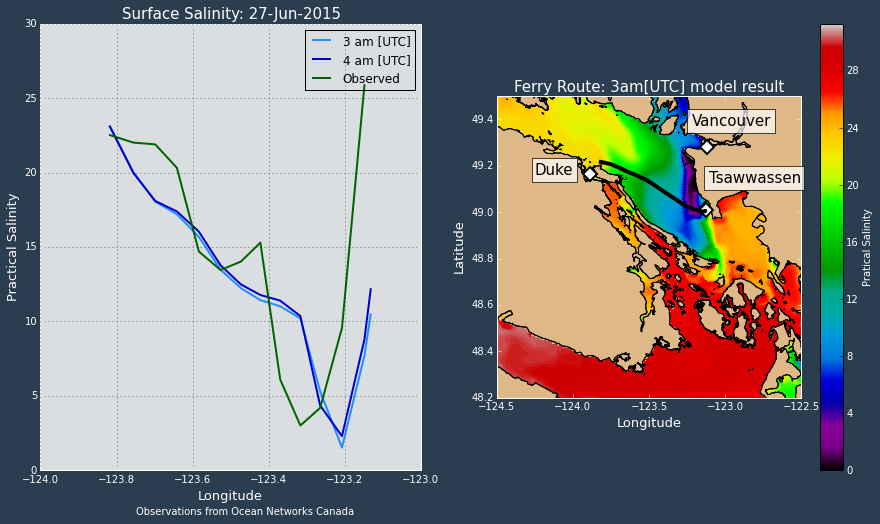

In [76]:
## original plot
fig = salinity_ferry_route(grid_T_hr, bathy, PNW_coastline,sal_hr_ori, saline)

New June 28

In [77]:
saline=sio.loadmat('/ocean/jieliu/research/meopar\
/autodataupdate/ferrydata/SBE1920150627.mat')

In [78]:
run_date = datetime.datetime(2015,6,28)
# Results dataset location
results_home = '/ocean/jieliu/research/meopar/river-treatment/14days_norefraserxml/'
results_dir = os.path.join(results_home, run_date.strftime('%d%b%y').lower())

In [79]:
grid_T_hr = results_dataset('1h', 'grid_T', results_dir)
bathy = nc.Dataset('/ocean/jieliu/research/meopar/river-treatment/bathy_meter_SalishSea5.nc')
PNW_coastline = sio.loadmat('/ocean/rich/more/mmapbase/bcgeo/PNW.mat')
filepath_name = date_more(run_date.year,run_date.month,run_date.day,run_date.day,'1h','grid_T')
latitude=grid_T_hr.variables['nav_lat'] 
longitude=grid_T_hr.variables['nav_lon']
sal_hr = grid_T_hr.variables['vosaline']
t, z = 3, 0
sal_hr = np.ma.masked_values(sal_hr[t, z], 0)

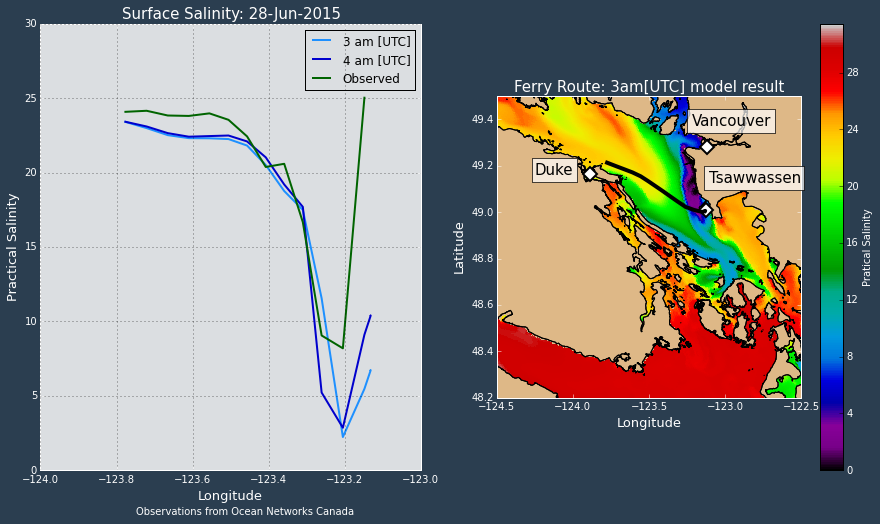

In [80]:
##new result June 28 
fig = salinity_ferry_route(grid_T_hr, bathy, PNW_coastline, sal_hr, saline)

* Position of plume seems to be correct but still not match the salinity values

original June 28

In [81]:
run_date = datetime.datetime(2015,6,28)
# Results dataset location
results_home = '/data/dlatorne/MEOPAR/SalishSea/nowcast/'
results_dir = os.path.join(results_home, run_date.strftime('%d%b%y').lower())

In [82]:
grid_T_hr = results_dataset('1h', 'grid_T', results_dir)
bathy = nc.Dataset('/data/nsoontie/MEOPAR/NEMO-forcing/grid/bathy_meter_SalishSea2.nc')
PNW_coastline = sio.loadmat('/ocean/rich/more/mmapbase/bcgeo/PNW.mat')
filepath_name = date_more(run_date.year,run_date.month,run_date.day,run_date.day,'1h','grid_T')
latitude=grid_T_hr.variables['nav_lat'] 
longitude=grid_T_hr.variables['nav_lon']
sal_hr_ori = grid_T_hr.variables['vosaline']
t, z = 3, 0
sal_hr_ori = np.ma.masked_values(sal_hr_ori[t, z], 0)

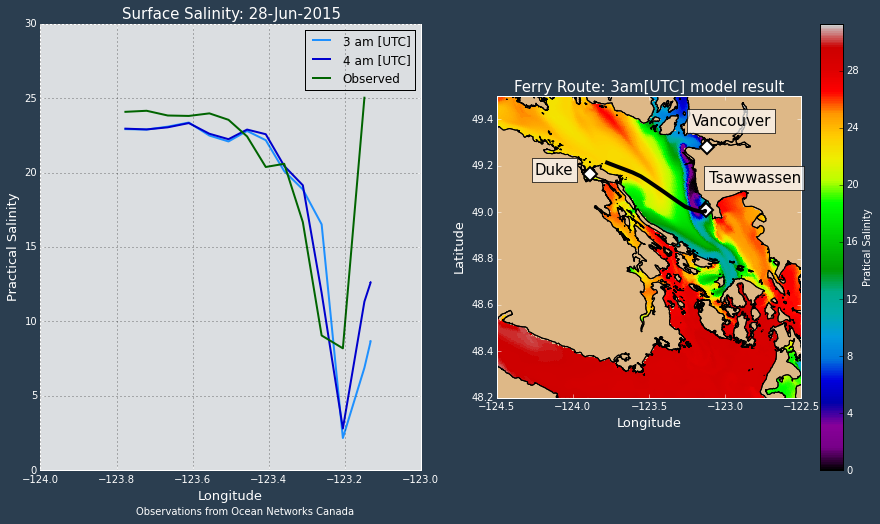

In [83]:
## original plot
fig = salinity_ferry_route(grid_T_hr, bathy, PNW_coastline,sal_hr_ori, saline)

New June 29

In [84]:
saline=sio.loadmat('/ocean/jieliu/research/meopar\
/autodataupdate/ferrydata/SBE1920150628.mat')

In [85]:
run_date = datetime.datetime(2015,6,29)
# Results dataset location
results_home = '/ocean/jieliu/research/meopar/river-treatment/14days_norefraserxml/'
results_dir = os.path.join(results_home, run_date.strftime('%d%b%y').lower())

In [86]:
grid_T_hr = results_dataset('1h', 'grid_T', results_dir)
bathy = nc.Dataset('/ocean/jieliu/research/meopar/river-treatment/bathy_meter_SalishSea5.nc')
PNW_coastline = sio.loadmat('/ocean/rich/more/mmapbase/bcgeo/PNW.mat')
filepath_name = date_more(run_date.year,run_date.month,run_date.day,run_date.day,'1h','grid_T')
latitude=grid_T_hr.variables['nav_lat'] 
longitude=grid_T_hr.variables['nav_lon']
sal_hr = grid_T_hr.variables['vosaline']
t, z = 3, 0
sal_hr = np.ma.masked_values(sal_hr[t, z], 0)

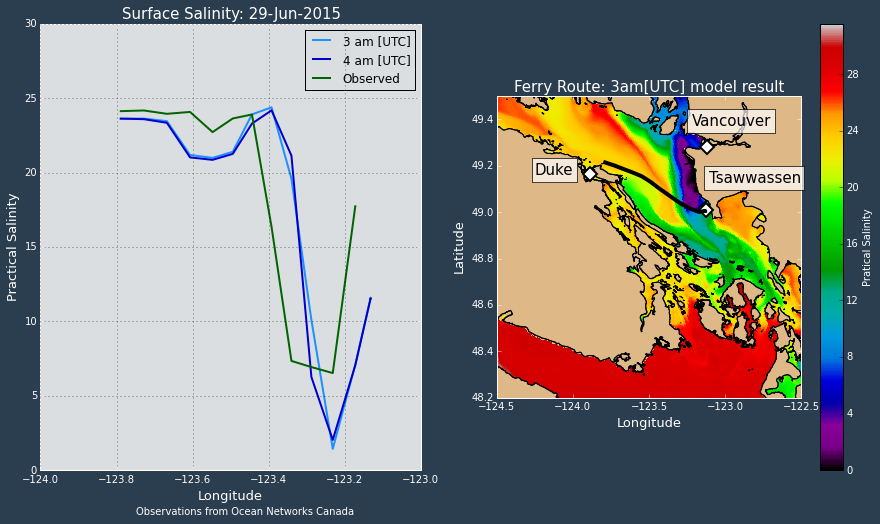

In [87]:
##new result June 29 
fig = salinity_ferry_route(grid_T_hr, bathy, PNW_coastline, sal_hr, saline)

* Much more similar salinity variation trend compared with obs than original, but with offshore fresher and further offshore area saltier.

original June 29

In [88]:
run_date = datetime.datetime(2015,6,29)
# Results dataset location
results_home = '/data/dlatorne/MEOPAR/SalishSea/nowcast/'
results_dir = os.path.join(results_home, run_date.strftime('%d%b%y').lower())

In [89]:
grid_T_hr = results_dataset('1h', 'grid_T', results_dir)
bathy = nc.Dataset('/data/nsoontie/MEOPAR/NEMO-forcing/grid/bathy_meter_SalishSea2.nc')
PNW_coastline = sio.loadmat('/ocean/rich/more/mmapbase/bcgeo/PNW.mat')
filepath_name = date_more(run_date.year,run_date.month,run_date.day,run_date.day,'1h','grid_T')
latitude=grid_T_hr.variables['nav_lat'] 
longitude=grid_T_hr.variables['nav_lon']
sal_hr_ori = grid_T_hr.variables['vosaline']
t, z = 3, 0
sal_hr_ori = np.ma.masked_values(sal_hr_ori[t, z], 0)

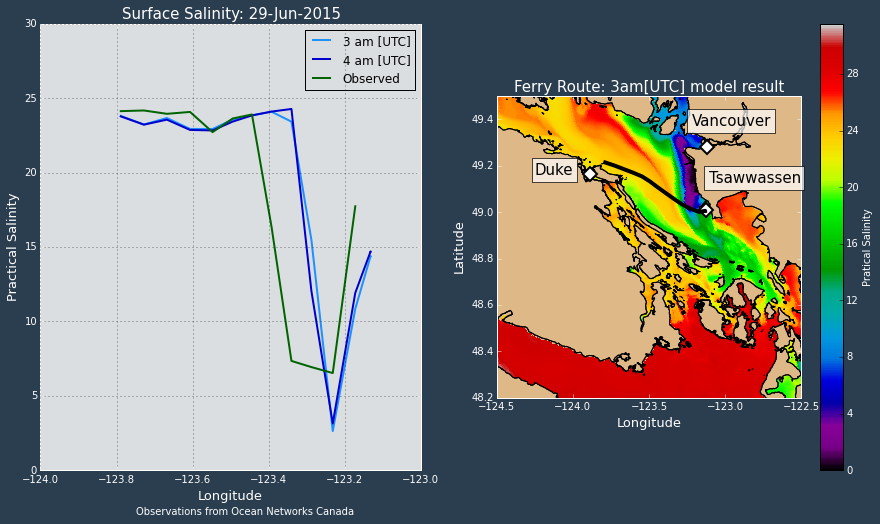

In [90]:
## original plot
fig = salinity_ferry_route(grid_T_hr, bathy, PNW_coastline,sal_hr_ori, saline)